In [1]:
from utils import *

In [6]:
CONST_COLUMNS = [
    'Stellensubart_1', 
    'Stellensubart_2',
    'Stellensubart_3',
    'Stellensubart_4',
    *[f"T{i}" for i in range(1, 35)],
    *[f"TD{i:02d}" for i in range(1, 35)],
    "Preis",
    "Beleuchtet",
    "Laenge",
    "Breite",
    "Eigenfläche",
#     "PPSVACWert",
    "Qid",
    "GJ",
]

In [39]:
len(CONST_COLUMNS)

79

In [7]:
data = pd.read_pickle("../data/decade_price_data_combined_01_09.pkl")

In [8]:
distance_2018 = pd.read_csv(
    "../data/distances/distances_2018_new_algo_200.csv"
).set_index("Qid_1")
distance_2019 = pd.read_csv(
    "../data/distances/distances_2019_new_algo_200.csv"
).set_index("Qid_1")
distance_2020 = pd.read_csv(
    "../data/distances/distances_2020_new_algo_200.csv"
).set_index("Qid_1")
distance_2021 = pd.read_csv(
    "../data/distances/distances_2021_new_algo_200.csv"
).set_index("Qid_1")
distance_2022 = pd.read_csv(
    "../data/distances/distances_2022_new_algo_200.csv"
).set_index("Qid_1")

In [9]:
cleaned_data = data.sort_values(by=["Qid", "GJ"]).set_index("Qid", drop=False)
cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

# Normalize cols

In [13]:
list_of_t =['TD01', 'TD02', 'TD03', 'TD04',
           'TD05', 'TD06', 'TD07', 'TD08', 'TD09', 'TD10', 'TD11', 'TD12', 'TD13',
           'TD14', 'TD15', 'TD16', 'TD17', 'TD18', 'TD19', 'TD20', 'TD21', 'TD22',
           'TD23', 'TD24', 'TD25', 'TD26', 'TD27', 'TD28', 'TD29', 'TD30', 'TD31',
           'TD32', 'TD33', 'TD34']

for i in list_of_t:
    cleaned_data[i] = (
        cleaned_data[i] - cleaned_data[i].mean()
    ) / cleaned_data[i].std()

cleaned_data.Preis = (
    cleaned_data.Preis - cleaned_data.Preis.mean()
) / cleaned_data.Preis.std()
cleaned_data.Laenge = (
    cleaned_data.Laenge - cleaned_data.Laenge.mean()
) / cleaned_data.Laenge.std()
cleaned_data.Breite = (
    cleaned_data.Breite - cleaned_data.Breite.mean()
) / cleaned_data.Breite.std()
# cleaned_data.PPSVACWert = (
#     cleaned_data.PPSVACWert - cleaned_data.PPSVACWert.mean()
# ) / cleaned_data.PPSVACWert.std()

In [14]:
data_2018 = cleaned_data[cleaned_data.GJ == 2018].drop(columns=["Qid", "GJ"]).copy()
data_2019 = cleaned_data[cleaned_data.GJ == 2019].drop(columns=["Qid", "GJ"]).copy()
data_2020 = cleaned_data[cleaned_data.GJ == 2020].drop(columns=["Qid", "GJ"]).copy()
data_2021 = cleaned_data[cleaned_data.GJ == 2021].drop(columns=["Qid", "GJ"]).copy()
data_2022 = cleaned_data[cleaned_data.GJ == 2022].drop(columns=["Qid", "GJ"]).copy()
data_2023 = cleaned_data[cleaned_data.GJ == 2023].drop(columns=["Qid", "GJ"]).copy()

In [15]:
data_2023.loc[:, "T1":"T22"] = data_2023.loc[:, "T1":"T22"].replace(-1, 0)

In [16]:
all_valid_qids = cleaned_data[cleaned_data.Eigenfläche == 1].Qid.unique()

In [17]:
qid_train, qid_val = train_test_split(all_valid_qids, test_size=0.05, random_state=666)

# Data Loading

In [21]:
def DataPreprocessor(qids):
    
    MAX_NEIGH = 10
    
    columns_to_drop = [
#         "PPSVACWert",
        *[f"T{i}" for i in range(1, 35)],
        *[f"TD{i:02d}" for i in range(1, 35)],
    ]

    global data_2018, data_2019, data_2020, data_2021, data_2022, data_2023
    global distance_2018, distance_2019, distance_2020, distance_2021, distance_2022
    X, x, y = [], [], []

    all_year_data = [data_2018, data_2019, data_2020, data_2021, data_2022]
    all_year_distances = [
        distance_2018,
        distance_2019,
        distance_2020,
        distance_2021,
        distance_2022,
    ]

    for idx, qid in enumerate(tqdm(qids)):
        
        if (data_2023.index == qid).sum():

            neighbours_features = []

            for year_data, year_distances in zip(all_year_data, all_year_distances):
                current_distances = year_distances[year_distances.index == qid]

                if (current_distances.shape[0] != 0) and ((year_data.index == qid).sum() != 0):
                    current_year_neighbours = current_distances[
                        current_distances.Qid_2 != qid
                    ]
#                     current_year_neighbours_data = torch.from_numpy(
#                         year_data.loc[current_year_neighbours.Qid_2].values
#                     )
                    
                    current_year_neighbours_data = torch.from_numpy(
                        year_data[year_data.index.isin(current_year_neighbours.Qid_2)].values
                    )
                    current_year_neighbours_data_padded = pad(
                        current_year_neighbours_data,
                        (0, 0, 0, MAX_NEIGH - current_year_neighbours_data.shape[0]),
                        "constant",
                        0,
                    )

                    current_year_self_data = torch.from_numpy(year_data.loc[qid].values)

                    if (current_year_self_data.ndim == 2) and (
                        current_year_self_data.shape[0] > 1
                    ):
                        current_year_self_data = current_year_self_data[0]

                    current_year_data_point = torch.cat(
                        [current_year_self_data[None], current_year_neighbours_data_padded],
                        dim=0,
                    )

                else:
                    # Fill with dummy zeros
                    current_year_data_point = torch.zeros(11, 77)

                neighbours_features.append(current_year_data_point)


            self_data_2023 = torch.from_numpy(
                data_2023.loc[qid].drop(labels=columns_to_drop).values
            )

            neighbours_features = torch.stack(neighbours_features, dim=0)
            label = torch.tensor(data_2023.loc[qid, "T1":"T22"].mean())

            X.append(neighbours_features)
            x.append(self_data_2023)
            y.append(label)

    X = torch.stack(X, dim=0)
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)

    return X, x, y

In [22]:
X_train, x_train, y_train = DataPreprocessor(qid_train)

100%|█████████████████████████████████████| 63586/63586 [11:05<00:00, 95.53it/s]


In [23]:
torch.save(X_train, "./data/X_train_lstm_decade_price_without_ppsvacwert.pt")
torch.save(x_train, "./data/x_train_lstm_decade_price_without_ppsvacwert.pt")
torch.save(y_train, "./data/y_train_lstm_decade_price_without_ppsvacwert.pt")

In [24]:
X_val, x_val, y_val = DataPreprocessor(qid_val)

100%|███████████████████████████████████████| 3347/3347 [00:35<00:00, 94.12it/s]


In [25]:
torch.save(X_val, "./data/X_val_lstm_decade_price_without_ppsvacwert.pt")
torch.save(x_val, "./data/x_val_lstm_decade_price_without_ppsvacwert.pt")
torch.save(y_val, "./data/y_val_lstm_decade_price_without_ppsvacwert.pt")

In [26]:
test_qids = np.array([9333, 9855, 9673, 9860])

In [27]:
# # loading test data
X_test, x_test, y_test = DataPreprocessor(test_qids)

torch.save(X_test, "./data/X_test_lstm_decade_price_without_ppsvacwert.pt")
torch.save(x_test, "./data/x_test_lstm_decade_price_without_ppsvacwert.pt")
torch.save(y_test, "./data/y_test_lstm_decade_price_without_ppsvacwert.pt")

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 74.46it/s]


In [28]:
qids=np.load('../data/val_qids_1000.npy')
qids.sort()

In [29]:
X_test_1000, x_test_1000, y_test_1000 = DataPreprocessor(qids)

100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


In [30]:
torch.save(X_test_1000, "./data/X_val_1000__without_ppsvacwert.pt")
torch.save(x_test_1000, "./data/x_val_1000__without_ppsvacwert.pt")
torch.save(y_test_1000, "./data/y_val_1000__without_ppsvacwert.pt")

# Models

In [31]:
from utils import *

In [47]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 68, input_size)

        # self.sigmoid  = nn.Sigmoid()

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)

        # out = self.sigmoid(out)

        return out
    
    


In [48]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_X, path_x, path_y, p=0.1, smooth_labels=False):
        
        self.data_X = torch.load(path_X)
        self.data_X = self.data_X.permute(0, 1, 3, 2)
        self.data_x = torch.load(path_x)
        self.data_y = torch.load(path_y)

        self.p = p

    def __getitem__(self, index):
        if torch.rand(1) < self.p:
            return self.__transform(
                self.data_X[index].clone(),
                self.data_x[index].clone(),
                self.data_y[index].clone(),
            )
        else:
            return (
                self.data_X[index],
                self.data_x[index],
                self.data_y[index]
            )

    def __len__(self):
        return len(self.data_X)

    def __transform(self, item_X, item_x, item_y, k=2):
        max_price = max(item_X[:, -6, 0])
        item_x[-5] = k * max_price
        item_y = item_y * 0

        return item_X, item_x, item_y

# Defining hyperparametrs

In [49]:
BATCH_SIZE = 64
LEARNING_RATE = 0.00003

In [50]:
model = LSTMModel(77, 512, 5, 1).to(DEVICE)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, LEARNING_RATE, LEARNING_RATE*10, mode="exp_range", cycle_momentum=False)

In [51]:
train_dataset = CustomDataset(
    "./data/X_train_lstm_decade_price_without_ppsvacwert.pt",
    "./data/x_train_lstm_decade_price_without_ppsvacwert.pt",
    "./data/y_train_lstm_decade_price_without_ppsvacwert.pt",
)

val_dataset = CustomDataset(
    "./data/X_val_lstm_decade_price_without_ppsvacwert.pt",
    "./data/x_val_lstm_decade_price_without_ppsvacwert.pt",
    "./data/y_val_lstm_decade_price_without_ppsvacwert.pt",
)

In [52]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)

In [54]:
num_epochs = 100
history = []
val_min_loss = None
model_name = input("Input proper model name:\t")

for epoch in range(num_epochs):
    train_running_loss = 0.0
    model.train()

    for batch in tqdm(train_dataloader, position=0, leave=True):
        # Every data instance is an input + label pair
        X_train1 = batch[0].to(torch.float32).to(DEVICE)
        x_train1 = batch[1].to(torch.float32).to(DEVICE)
        y_train1 = batch[2].to(torch.float32).to(DEVICE)
        outputs = model(X_train1, x_train1)
        loss = criterion(outputs, y_train1.view(-1, 1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()

    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, position=0, leave=True):
            # Every data instance is an input + label pair
            X_val1 = batch[0].to(torch.float32).to(DEVICE)
            x_val1 = batch[1].to(torch.float32).to(DEVICE)
            y_val1 = batch[2].to(torch.float32).to(DEVICE)
            outputs = model(X_val1, x_val1)
            loss = criterion(outputs, y_val1.view(-1, 1))
            val_running_loss += loss.item()

    mean_train_loss = train_running_loss / len(train_dataloader)
    mean_val_loss = val_running_loss / len(val_dataloader)

    # scheduler.step(mean_val_loss)

    if val_min_loss is None:
        val_min_loss = mean_val_loss
    elif mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        torch.save(model.state_dict(), f"./models/{model_name}.pth")

    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
    )

Input proper model name:	without_ppsvacwert


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.45it/s]


Epoch [1/100]
Train Loss: 0.1508
Val Loss: 0.1379


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 198.86it/s]


Epoch [2/100]
Train Loss: 0.1262
Val Loss: 0.1173


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 197.96it/s]


Epoch [3/100]
Train Loss: 0.115
Val Loss: 0.1097


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 197.66it/s]


Epoch [4/100]
Train Loss: 0.1084
Val Loss: 0.1013


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 226.85it/s]


Epoch [5/100]
Train Loss: 0.1051
Val Loss: 0.1061


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 227.45it/s]


Epoch [6/100]
Train Loss: 0.1057
Val Loss: 0.1077


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 227.77it/s]


Epoch [7/100]
Train Loss: 0.1071
Val Loss: 0.1077


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 231.15it/s]


Epoch [8/100]
Train Loss: 0.1019
Val Loss: 0.0962


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 274.69it/s]


Epoch [9/100]
Train Loss: 0.0963
Val Loss: 0.0924


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 242.06it/s]


Epoch [10/100]
Train Loss: 0.0941
Val Loss: 0.099


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 232.52it/s]


Epoch [11/100]
Train Loss: 0.0956
Val Loss: 0.102


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 234.62it/s]


Epoch [12/100]
Train Loss: 0.0976
Val Loss: 0.099


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 238.72it/s]


Epoch [13/100]
Train Loss: 0.0945
Val Loss: 0.0946


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 223.23it/s]


Epoch [14/100]
Train Loss: 0.0902
Val Loss: 0.088


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 213.53it/s]


Epoch [15/100]
Train Loss: 0.0898
Val Loss: 0.0949


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 210.36it/s]


Epoch [16/100]
Train Loss: 0.0926
Val Loss: 0.0921


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 208.87it/s]


Epoch [17/100]
Train Loss: 0.094
Val Loss: 0.097


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 212.92it/s]


Epoch [18/100]
Train Loss: 0.091
Val Loss: 0.0883


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 213.49it/s]


Epoch [19/100]
Train Loss: 0.0878
Val Loss: 0.0862


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 198.55it/s]


Epoch [20/100]
Train Loss: 0.0884
Val Loss: 0.0892


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 194.65it/s]


Epoch [21/100]
Train Loss: 0.0917
Val Loss: 0.0961


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 192.28it/s]


Epoch [22/100]
Train Loss: 0.0914
Val Loss: 0.0899


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 188.87it/s]


Epoch [23/100]
Train Loss: 0.0884
Val Loss: 0.0857


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 192.55it/s]


Epoch [24/100]
Train Loss: 0.0857
Val Loss: 0.086


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 194.88it/s]


Epoch [25/100]
Train Loss: 0.0878
Val Loss: 0.0992


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.01it/s]


Epoch [26/100]
Train Loss: 0.089
Val Loss: 0.094


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.53it/s]


Epoch [27/100]
Train Loss: 0.0891
Val Loss: 0.092


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 198.11it/s]


Epoch [28/100]
Train Loss: 0.0862
Val Loss: 0.0865


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.46it/s]


Epoch [29/100]
Train Loss: 0.084
Val Loss: 0.0866


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 197.76it/s]


Epoch [30/100]
Train Loss: 0.0864
Val Loss: 0.0937


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 193.52it/s]


Epoch [31/100]
Train Loss: 0.0885
Val Loss: 0.0906


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 223.73it/s]


Epoch [32/100]
Train Loss: 0.0876
Val Loss: 0.087


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 213.45it/s]


Epoch [33/100]
Train Loss: 0.0842
Val Loss: 0.0842


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 209.97it/s]


Epoch [34/100]
Train Loss: 0.0837
Val Loss: 0.0833


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 188.44it/s]


Epoch [35/100]
Train Loss: 0.0858
Val Loss: 0.0932


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.82it/s]


Epoch [36/100]
Train Loss: 0.088
Val Loss: 0.0884


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 194.46it/s]


Epoch [37/100]
Train Loss: 0.085
Val Loss: 0.0866


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.77it/s]


Epoch [38/100]
Train Loss: 0.0825
Val Loss: 0.0844


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 193.49it/s]


Epoch [39/100]
Train Loss: 0.0826
Val Loss: 0.0865


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 186.54it/s]


Epoch [40/100]
Train Loss: 0.0859
Val Loss: 0.0903


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.97it/s]


Epoch [41/100]
Train Loss: 0.0861
Val Loss: 0.0889


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 192.60it/s]


Epoch [42/100]
Train Loss: 0.0839
Val Loss: 0.0878


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.20it/s]


Epoch [43/100]
Train Loss: 0.0815
Val Loss: 0.0881


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 199.99it/s]


Epoch [44/100]
Train Loss: 0.0823
Val Loss: 0.0882


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.49it/s]


Epoch [45/100]
Train Loss: 0.0851
Val Loss: 0.09


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.36it/s]


Epoch [46/100]
Train Loss: 0.084
Val Loss: 0.0891


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 193.09it/s]


Epoch [47/100]
Train Loss: 0.0818
Val Loss: 0.0836


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 194.15it/s]


Epoch [48/100]
Train Loss: 0.0802
Val Loss: 0.0852


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.85it/s]


Epoch [49/100]
Train Loss: 0.0823
Val Loss: 0.0896


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 198.13it/s]


Epoch [50/100]
Train Loss: 0.0844
Val Loss: 0.0963


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 199.72it/s]


Epoch [51/100]
Train Loss: 0.083
Val Loss: 0.0878


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.81it/s]


Epoch [52/100]
Train Loss: 0.0802
Val Loss: 0.0853


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 199.30it/s]


Epoch [53/100]
Train Loss: 0.0788
Val Loss: 0.0862


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 193.64it/s]


Epoch [54/100]
Train Loss: 0.0809
Val Loss: 0.0875


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.41it/s]


Epoch [55/100]
Train Loss: 0.0834
Val Loss: 0.0855


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 198.48it/s]


Epoch [56/100]
Train Loss: 0.0808
Val Loss: 0.0847


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 198.01it/s]


Epoch [57/100]
Train Loss: 0.0774
Val Loss: 0.0848


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 197.34it/s]


Epoch [58/100]
Train Loss: 0.0781
Val Loss: 0.0882


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.53it/s]


Epoch [59/100]
Train Loss: 0.081
Val Loss: 0.0862


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 193.91it/s]


Epoch [60/100]
Train Loss: 0.0819
Val Loss: 0.0856


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 197.96it/s]


Epoch [61/100]
Train Loss: 0.0791
Val Loss: 0.0844


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 203.65it/s]


Epoch [62/100]
Train Loss: 0.0763
Val Loss: 0.084


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.00it/s]


Epoch [63/100]
Train Loss: 0.0774
Val Loss: 0.0905


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 200.52it/s]


Epoch [64/100]
Train Loss: 0.0807
Val Loss: 0.0935


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 199.78it/s]


Epoch [65/100]
Train Loss: 0.0802
Val Loss: 0.0859


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 193.76it/s]


Epoch [66/100]
Train Loss: 0.0772
Val Loss: 0.0871


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.56it/s]


Epoch [67/100]
Train Loss: 0.0752
Val Loss: 0.0872


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.10it/s]


Epoch [68/100]
Train Loss: 0.0771
Val Loss: 0.0855


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.47it/s]


Epoch [69/100]
Train Loss: 0.08
Val Loss: 0.0877


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 197.34it/s]


Epoch [70/100]
Train Loss: 0.0783
Val Loss: 0.0864


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.16it/s]


Epoch [71/100]
Train Loss: 0.0753
Val Loss: 0.085


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 196.23it/s]


Epoch [72/100]
Train Loss: 0.0737
Val Loss: 0.0852


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 197.32it/s]


Epoch [73/100]
Train Loss: 0.0767
Val Loss: 0.091


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 184.88it/s]


Epoch [74/100]
Train Loss: 0.0788
Val Loss: 0.091


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 194.96it/s]


Epoch [75/100]
Train Loss: 0.0768
Val Loss: 0.0848


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 202.37it/s]


Epoch [76/100]
Train Loss: 0.0739
Val Loss: 0.0859


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 198.59it/s]


Epoch [77/100]
Train Loss: 0.0728
Val Loss: 0.0889


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 194.68it/s]


Epoch [78/100]
Train Loss: 0.0758
Val Loss: 0.0881


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 195.58it/s]


Epoch [79/100]
Train Loss: 0.0778
Val Loss: 0.0883


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 314.49it/s]


Epoch [80/100]
Train Loss: 0.0746
Val Loss: 0.0863


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 351.47it/s]


Epoch [81/100]
Train Loss: 0.0715
Val Loss: 0.0886


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 351.76it/s]


Epoch [82/100]
Train Loss: 0.0717
Val Loss: 0.0901


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 352.20it/s]


Epoch [83/100]
Train Loss: 0.0751
Val Loss: 0.0891


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 352.89it/s]


Epoch [84/100]
Train Loss: 0.0757
Val Loss: 0.0876


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 348.83it/s]


Epoch [85/100]
Train Loss: 0.0725
Val Loss: 0.0865


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 350.88it/s]


Epoch [86/100]
Train Loss: 0.0693
Val Loss: 0.0856


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 353.47it/s]


Epoch [87/100]
Train Loss: 0.0714
Val Loss: 0.0869


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 282.72it/s]


Epoch [88/100]
Train Loss: 0.0741
Val Loss: 0.0906


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 347.47it/s]


Epoch [89/100]
Train Loss: 0.0735
Val Loss: 0.0852


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 286.31it/s]


Epoch [90/100]
Train Loss: 0.0701
Val Loss: 0.0867


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 350.42it/s]


Epoch [91/100]
Train Loss: 0.0678
Val Loss: 0.086


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 299.89it/s]


Epoch [92/100]
Train Loss: 0.0708
Val Loss: 0.0931


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 313.38it/s]


Epoch [93/100]
Train Loss: 0.0735
Val Loss: 0.0897


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 362.83it/s]


Epoch [94/100]
Train Loss: 0.0716
Val Loss: 0.0874


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 368.14it/s]


Epoch [95/100]
Train Loss: 0.068
Val Loss: 0.0888


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 363.07it/s]


Epoch [96/100]
Train Loss: 0.0666
Val Loss: 0.0894


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 362.90it/s]


Epoch [97/100]
Train Loss: 0.0695
Val Loss: 0.0904


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 363.83it/s]


Epoch [98/100]
Train Loss: 0.0721
Val Loss: 0.0939


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 358.90it/s]


Epoch [99/100]
Train Loss: 0.069
Val Loss: 0.0864


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 357.30it/s]

Epoch [100/100]
Train Loss: 0.0653
Val Loss: 0.0904


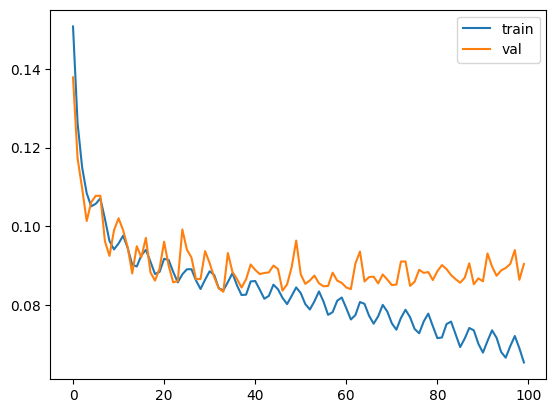

In [55]:
plt.plot(history)
plt.legend(["train", "val"]);

# Evaluation

In [56]:
model.load_state_dict(torch.load(f"./models/{model_name}.pth"))
model.eval()
X_val = val_dataset.data_X
x_val = val_dataset.data_x
y_val = val_dataset.data_y
preds = (
    torch.clamp(
    model(X_val.to(torch.float32).to(DEVICE), x_val.to(torch.float32).to(DEVICE))
    .detach()
    .cpu()
    , min=0, max=1)
    .numpy()
    )
ground_truth = (y_val).numpy()

## MAE

In [57]:
print(np.abs(preds[..., 0] - ground_truth).mean().round(4))

0.0894


## Kernel Density Estimation plot

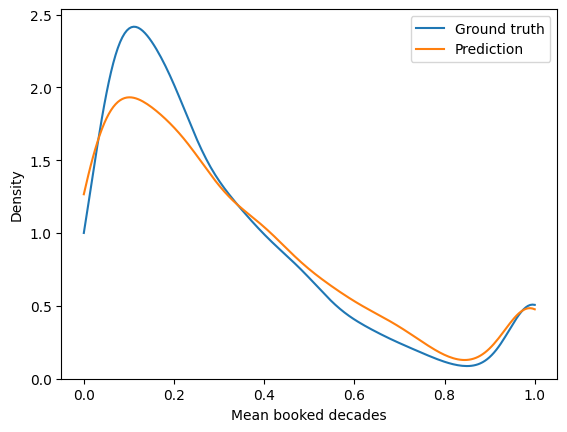

In [58]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sns.distplot(preds[..., 0],  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Ground truth')
    sns.distplot(ground_truth,  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Prediction')
    plt.legend();
    plt.xlabel("Mean booked decades");

## Scatter plot of ground_truth and preds

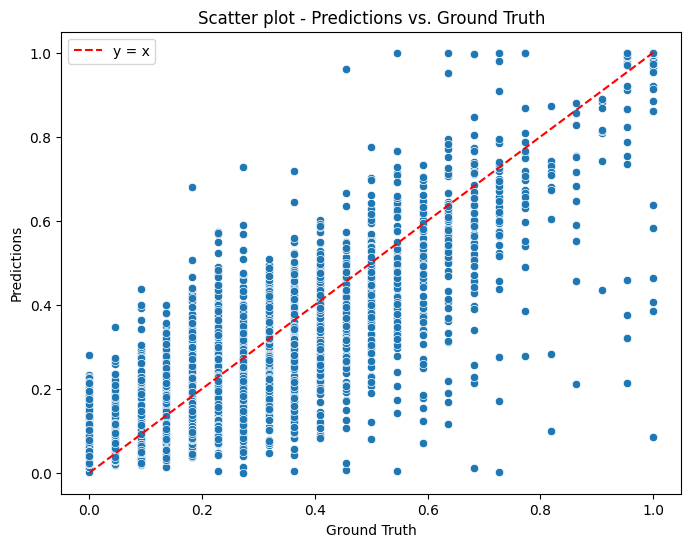

In [59]:
# Create a diagonal line for y = x
x_values = np.linspace(
    min(preds[..., 0].min(), ground_truth.min()),
    max(preds[..., 0].max(), ground_truth.max()),
    100,
)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ground_truth, y=preds[..., 0])

# Plot the diagonal line
plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

# Set labels and title
plt.xlabel("Ground Truth")

plt.ylabel("Predictions")
plt.title("Scatter plot - Predictions vs. Ground Truth")

# Show the plot
plt.legend()
plt.show()